<a href="https://colab.research.google.com/github/brendanhasz/embedding-regression/blob/master/TFP_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tfp-nightly

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

np.random.seed(1234)
tf.set_random_seed(1234)

# Data

In [0]:
# Generate fake data
D = 4
N = 100
W = np.random.randn(D).astype(np.float32)
x = np.random.randn(N, D).astype(np.float32)
noise = np.random.randn(N).astype(np.float32)
y = np.matmul(x, W) + noise

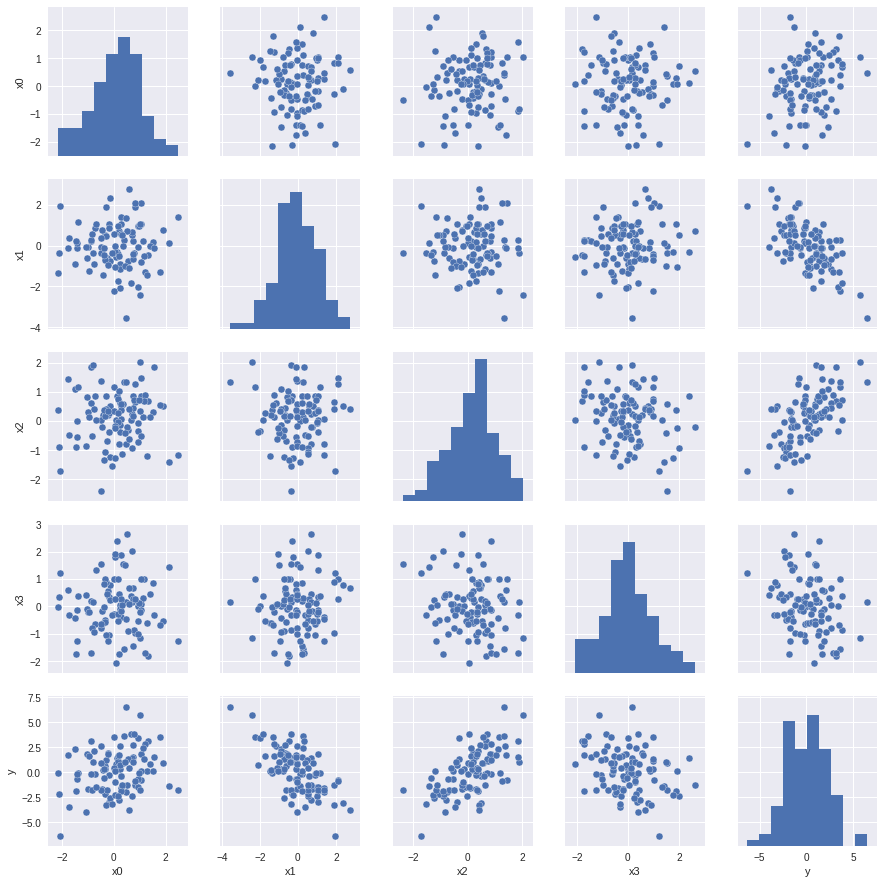

In [4]:
# Show data
sns.pairplot(pd.DataFrame(np.c_[x, y],
                          columns=['x0', 'x1', 'x2', 'x3', 'y']))
plt.show()

# Model

A basic Bayesian linear regression

\begin{align*}
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{HalfNormal}(1) \\
y_i &\sim \text{Normal}(x_i^\top \beta, ~ \sigma^2)
\end{align*}



In [0]:
def linear_regression(features):
  """Bayesian linear regression, which returns predictions given features."""
  D = features.shape[1]
  coeffs = ed.Normal( #normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")
  noise_std = ed.HalfNormal( #half-normal prior on noise std
      scale=1.,
      name="noise_std")
  predictions = ed.Normal( #normally-distributed noise around predicted values
      loc=tf.matmul(features, coeffs),
      scale=noise_std,
      name="predictions")
  return predictions

log_joint = ed.make_log_joint_fn(linear_regression)

def target_log_prob_fn(coeffs, noise_std):
  """Target density."""
  return log_joint(
      features=x,
      coeffs=coeffs,
      noise_std=noise_std,
      predictions=y[:,np.newaxis])

# Bayesian Inference

Yadda yadda

In [6]:
# HMC Settings
num_results = int(10e3) #number of hmc iterations
n_burnin = int(5e3)
step_size = 0.05 #works w/ 100 datapoints?
num_leapfrog_steps = 2

# Parameter sizes
coeffs_size = [4,1]
noise_std_size = [1]

t0 = time.time()

# HMC transition kernel
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=step_size,
    num_leapfrog_steps=num_leapfrog_steps)

# Run the chain
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=n_burnin,
    kernel=kernel,
    current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.ones([], name='init_noise_std'),
    ])

coeffs, noise_std = states

with tf.Session() as sess:
  [
      coeffs_,
      noise_std_,
      is_accepted_,
  ] = sess.run([
      coeffs,
      noise_std,
      kernel_results.is_accepted,
  ])


# Remove samples from burn-in
coeffs_samples = coeffs_[n_burnin:,:,0]
noise_std_samples = noise_std_[n_burnin:]
accepted_samples = is_accepted_[n_burnin:]

print('Elapsed time: ', time.time()-t0)

Elapsed time:  7.215060234069824


Talk about acceptance rate.  

Sounds like an acceptance rate of about 0.234 is "optimal".  http://dx.doi.org/10.1214/aoap/1034625254


In [7]:
print('Acceptance rate: ', np.mean(accepted_samples))

Acceptance rate:  0.9254


TODO: talk about looking @ posterior distribution

dist is the posterior, solid line is true val, dotted lines show 95% conf interval

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

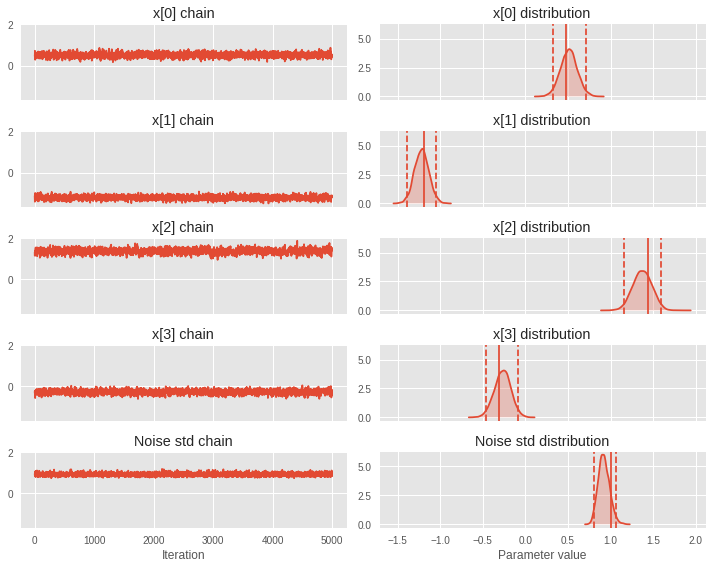

In [8]:
def chain_plot(data, title='', ax=None):
  if ax is None:
    ax = plt.gca()
  ax.plot(data)
  ax.title.set_text(title+" chain")
  
def post_plot(data, title='', ax=None, true=None, prc=95):
  if ax is None:
    ax = plt.gca()
  sns.kdeplot(data, ax=ax, shade=True)
  ax.axvline(x=np.percentile(data, (100-prc)/2), linestyle='--')
  ax.axvline(x=np.percentile(data, 100-(100-prc)/2), linestyle='--')
  ax.title.set_text(title+" distribution")
  if true is not None:
    ax.axvline(x=true)
    
def chain_post_plot(data, title='', ax=None, true=None):
  chain_plot(data, title=title, ax=ax[0])
  post_plot(data, title=title, ax=ax[1], true=true)
  
# Plot chains and distributions for coefficients
plt.style.use("ggplot")
fig, axes = plt.subplots(5, 2, sharex='col', sharey='col')
fig.set_size_inches(10, 8)
for i in range(4):
  chain_post_plot(coeffs_samples[:,i],
                  title="x[{}]".format(i),
                  ax=axes[i], true=W[i])
  
# and for noise std dev
chain_post_plot(noise_std_samples,
                title="Noise std",
                ax=axes[4], true=1)
  
axes[4][0].set_xlabel("Iteration")
axes[4][1].set_xlabel("Parameter value")
fig.tight_layout()
plt.show()

# Criticism

TODO

talk math, how you set the param values to the mean of their posterior dists, and then sample from the model, you can see "posterior predictive distributions" (but this is assuming the true params = the mean of the posterior, which the prediction interval above didn't)

Only captures aleatoric (noise) uncertainty.

Also then maybe should do the prediction intervals sectino after this one.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


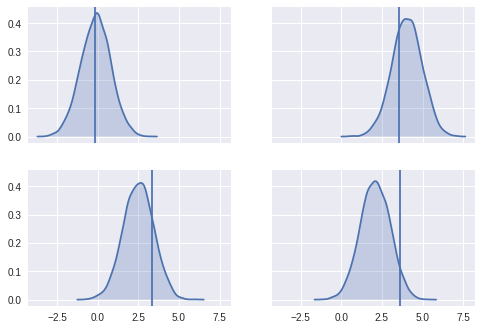

In [10]:
def interceptor(f, *args, **kwargs):
  name = kwargs.pop("name")
  if name == "coeffs":
    kwargs["value"] = np.reshape(np.mean(coeffs_samples, 0), (4,1))
  elif name == "noise_std":
    kwargs["value"] = np.mean(noise_std_samples, 0)
  return f(*args, **kwargs)

with ed.interception(interceptor):
  posterior = linear_regression(features=x)

with tf.Session() as sess:
  posterior_predictive = sess.run(
      posterior.distribution.sample(sample_shape=(5000)))

# TODO: ok so this is only showing prediction interval w/ 
# param values = mean posterior value for each param.  So we're only 
# seeing "irreducible" uncertainty and not model uncertainty

# Plot random datapoints and their posterior predictive intervals
sns.set()
fig, axes = plt.subplots(2, 2, sharex='all', sharey='all')
for i in range(2):
  for j in range(2):
    #ix = np.random.randint(0, N)
    ix = i*2+j
    sns.kdeplot(posterior_predictive[:,ix,0], shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y[ix])

TODO: then you can take the mean of the posterior predictive for each datapoint and plot the residuals.  In theory the residual distribution should look like the distribution you used to model the noise (in our case a normal distribution)

<function matplotlib.pyplot.plot>

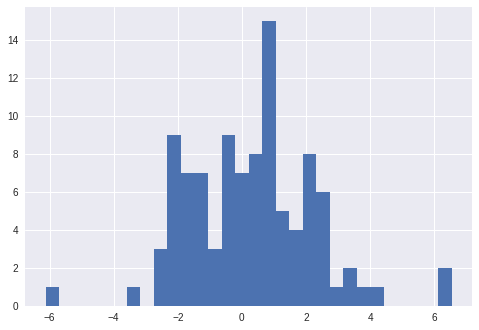

In [21]:
# Compute the mean posterior predictive for each datapoint
with tf.Session() as sess:
  residuals = sess.run(
      posterior.distribution.mean())
  #tho technically you want to generate posterior samples, and take the means of those...
  
# Plot the residual distribution
plt.figure()
#sns.kdeplot(residuals[:,0])
plt.hist(residuals[:,0], bins=30)
plt.plot

Hmm well it's not looking super normal... May want to relax the normal dist assumptions, perhaps use a t-distribution...

# Prediction intervals


TODO (generate prediction intervals for test data)

Captures both epistemic (model) + aleatoric (noise) uncertainty

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


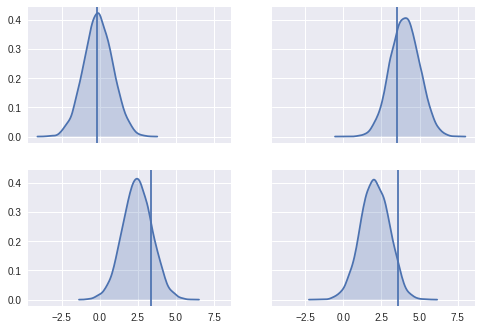

In [22]:
def prediction_distribution(X):
  # seems like there should be a way to do this like:
  #posterior = linear_regression(features=np.reshape(X, (len(X), 1)))
  #define param posterior vals somehow?
  #with tf.Session() as sess:
  #  prediction_samples = sess.run(posterior.distribution.sample(sample_shape=(n)))  
  predictions = np.matmul(X, coeffs_samples.transpose())
  noise = noise_std_samples*np.random.randn(noise_std_samples.shape[0])
  return predictions + noise

# Plot random datapoints and their prediction intervals
sns.set()
fig, axes = plt.subplots(2, 2, sharex='all', sharey='all')
for i in range(2):
  for j in range(2):
    #ix = np.random.randint(0, N)
    ix = i*2+j
    pred_dist = prediction_distribution(x[ix,:])
    sns.kdeplot(pred_dist, shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y[ix])

In [0]:
#TODO: TWO BAYESIAN NEURAL NETS, ONE predicts mean and the other predicts variance?
# fast_kde func which can do kde via lookup? for plotting the prediction intervals
# if you sample mu and sigma from the two bayesian neural nets
# then generate kde w/ mu + sigma for each sample

# TODO: EMBEDDING W/ THE LINEAR MODEL + W/ BAYESIAN NEURAL NETS
# but... With a 1dim embedding + a linear model, that's the same as a random effect? 
# And with regression you could do a >1 dim embedding, but if you're doing mcmc 
# the posterior will be super multimodal (same problem as trying to fit a hmm w hmc), 
# but will be ok with optimising.  
# Maybe use variational inf?  but dunno if that would try to capture all possible modes
# could also, just do optimizing, then set prior on embeddings = prod of normal prior
# and gaussian @ the embedding value found w/ optimizing?
# that would probs help keep the MCMC samples unimodal
# should test to see whether variational inf finds a single mode or tries to stretch
# the variational distribution over multiple modes

https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/bayesian_neural_network.py
https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout
  
  